# Topic modeling for gene-set libraries in Enrichr

In [1]:
%load_ext autoreload
%autoreload 2
import os, sys
import numpy as np
import pandas as pd

from sklearn import decomposition, metrics
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.neighbors import KNeighborsClassifier

import enrichr
import evaluations

In [2]:
sys.path.append('/Users/maayanlab/Documents/GitHub/tensorflow-playground/')
from nvdm import NVDM

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_context('talk')

# 0. Prepare data into matrix formats (terms by genes)

- Term-frequency (TF) matrix: will be used by LDA
- TF-IDF matrix: will be used by NMF, SVD

In [4]:
# Download enrichr libs 
lib_names = [
    'ChEA_2016', 'ENCODE_TF_ChIP-seq_2015', 'ENCODE_Histone_Modifications_2015',
    'TRANSFAC_and_JASPAR_PWMs', 'Genome_Browser_PWMs',
    'KEGG_2016', 'KEA_2015',
    'GO_Biological_Process_2018', 'GO_Cellular_Component_2018', 'GO_Molecular_Function_2018',
    'MGI_Mammalian_Phenotype_2017', 'Human_Phenotype_Ontology',
    'dbGaP', 
    'Genes_Associated_with_NIH_Grants',
    'Chromosome_Location_hg19',
    'Pfam_InterPro_Domains',
    'HomoloGene'
            ]
for lib_name in lib_names:
    print(lib_name)
    enrichr.get_library_filepath(lib_name)

ChEA_2016
ENCODE_TF_ChIP-seq_2015
ENCODE_Histone_Modifications_2015
TRANSFAC_and_JASPAR_PWMs
Genome_Browser_PWMs
KEGG_2016
KEA_2015
GO_Biological_Process_2018
GO_Cellular_Component_2018
GO_Molecular_Function_2018
MGI_Mammalian_Phenotype_2017
Human_Phenotype_Ontology
dbGaP
Genes_Associated_with_NIH_Grants
Chromosome_Location_hg19
Pfam_InterPro_Domains
HomoloGene


In [5]:
# Parse all gmts 
d_gmt = {}
for lib_name in lib_names:
    fp = enrichr.get_library_filepath(lib_name)
    d_gmt_i = enrichr.parse_gmt(fp, namespace=lib_name)
    d_gmt.update(d_gmt_i)

print('Number of gene sets:', len(d_gmt))

Number of gene sets: 50825


In [6]:
# term-frequency matrix (gene sets x genes)
tf_mat, genes = enrichr.gmt2mat(d_gmt, sparse_output=True, min_frequency=0)
tf_mat.shape

(50825, 63178)

In [7]:
# Examine gene frequency
gene_counts_df = pd.DataFrame({'count': np.asarray(tf_mat.sum(axis=0)).reshape(-1)}, index=genes)\
    .sort_values('count')
gene_counts_df.head(10)

count
$OC90$            1
LOC100040066      1
LOC100040061      1
LOC100040041      1
LOC100040040      1
LOC100040018      1
LOC100040006      1
LOC100039982      1
LOC100039964      1
LOC100039953      1

In [8]:
gene_counts_df.tail(10)

count
VEGFA    1355
MAPK1    1362
CTNNB1   1416
IL6      1420
NFKB1    1603
TGFB1    1623
EGFR     1672
TNF      1721
AKT1     1753
TP53     2651

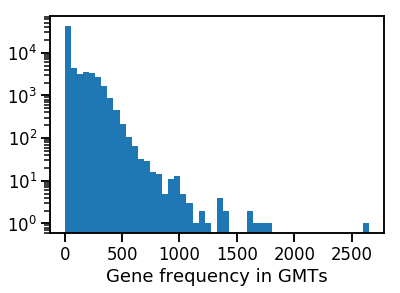

In [9]:
plt.hist(gene_counts_df['count'], bins=50, log=True);
plt.xlabel('Gene frequency in GMTs');

In [10]:
# Filter out rare genes
for cutoff in [1, 2, 5, 10, 15, 20, 25, 30]:
    mask = np.asarray(tf_mat.sum(axis=0)).reshape(-1) > cutoff
    print('cutoff = %d, genes left = %d' % (cutoff, mask.sum()))

cutoff = 1, genes left = 44029
cutoff = 2, genes left = 40390
cutoff = 5, genes left = 36417
cutoff = 10, genes left = 32309
cutoff = 15, genes left = 29188
cutoff = 20, genes left = 26962
cutoff = 25, genes left = 25409
cutoff = 30, genes left = 24184


In [11]:
cutoff = 10
mask = np.asarray(tf_mat.sum(axis=0)).reshape(-1) > cutoff
tf_mat = tf_mat[:, mask]
genes = genes[mask]
print(tf_mat.shape, genes.shape)

(50825, 32309) (32309,)


In [12]:
# TF-IDF normalization
tfidf = TfidfTransformer(norm='l2')
tfidf_mat = tfidf.fit_transform(tf_mat)
tfidf_mat.shape

(50825, 32309)

In [13]:
# Create a df for terms in gmt
terms_df = pd.DataFrame({
    'library': [ s.split('$')[0] for s in d_gmt.keys()],
    'term': [ s.split('$')[1] for s in d_gmt.keys()],
    'n_genes': [len(val) for val in d_gmt.values()]
}, index=list(d_gmt.keys()))
print(terms_df.shape)
terms_df.head()

(50825, 3)


library  \
ChEA_2016$BP1_19119308_ChIP-ChIP_Hs578T_Human       ChEA_2016   
ChEA_2016$FOXP1_22492998_ChIP-Seq_STRATIUM_Mouse    ChEA_2016   
ChEA_2016$E4F1_26484288_ChIP-Seq_MOUSE_EMBRYONI...  ChEA_2016   
ChEA_2016$RBPJ_22232070_ChIP-Seq_NCS_Mouse          ChEA_2016   
ChEA_2016$TCF21_23034159_ChIP-ChIP_E13_GONADS_Rat   ChEA_2016   

                                                                                                 term  \
ChEA_2016$BP1_19119308_ChIP-ChIP_Hs578T_Human                     BP1_19119308_ChIP-ChIP_Hs578T_Human   
ChEA_2016$FOXP1_22492998_ChIP-Seq_STRATIUM_Mouse               FOXP1_22492998_ChIP-Seq_STRATIUM_Mouse   
ChEA_2016$E4F1_26484288_ChIP-Seq_MOUSE_EMBRYONI...  E4F1_26484288_ChIP-Seq_MOUSE_EMBRYONIC_FIBROBL...   
ChEA_2016$RBPJ_22232070_ChIP-Seq_NCS_Mouse                           RBPJ_22232070_ChIP-Seq_NCS_Mouse   
ChEA_2016$TCF21_23034159_ChIP-ChIP_E13_GONADS_Rat             TCF21_23034159_ChIP-ChIP_E13_GONADS_Rat   

                                                    n_genes  
ChEA_2016$BP1_19119308_ChIP-ChIP_Hs578T_Human            18  
ChEA_2016$FOXP1_22492998_ChIP-Seq_STRATIUM_Mouse         26  
ChEA_2016$E4F1_26484288_ChIP-Seq_MOUSE_EMBRYONI...       30  
ChEA_2016$RBPJ_22232070_ChIP-Seq_NCS_Mouse               34  
ChEA_2016$TCF21_23034159_ChIP-ChIP_E13_GONADS_Rat        37

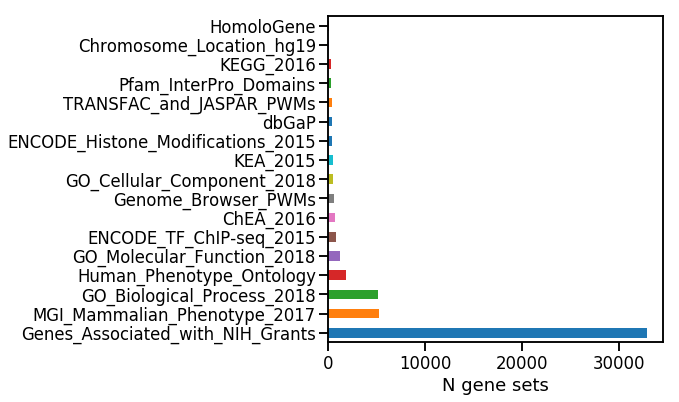

In [14]:
fig, ax = plt.subplots(figsize = (6,6))
ax = terms_df['library'].value_counts().plot(kind='barh', ax=ax)
ax.set_xlabel('N gene sets');

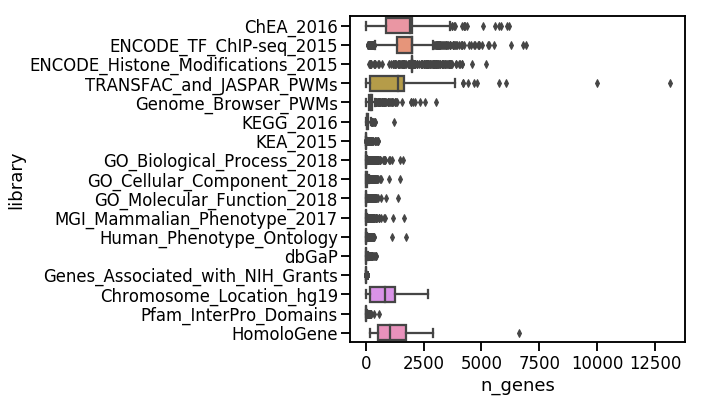

In [15]:
fig, ax = plt.subplots(figsize = (6,6))
ax = sns.boxplot(y='library', x='n_genes', data=terms_df, ax=ax)

# 1. Evaluate the similarity of topic models learned from individual libs (LDA only)

$Perplexity = 2^{H(p)} = 2^{-\sum_xp(x)log_2p(x))}$    

where $H(p)$ is the entropy of the distribution $p$ over its possible values $x$

In [16]:
n_topics = 100

In [16]:
# Run LDA on each lib individually, then compute perpexity on all
# very slow
# consider: https://docs.microsoft.com/en-us/python/api/nimbusml/nimbusml.feature_extraction.text.lightlda?view=nimbusml-py-latest
# n_topics = 50
n_topics = 100

n_libs = len(lib_names)
perplexity_mat = np.zeros((n_libs, n_libs))

lib_masks = [np.in1d(terms_df['library'], [lib_name]) for lib_name in lib_names]

for i, lib_name in enumerate(lib_names):
    tf_mat_sub = tf_mat[lib_masks[i]]
    print(lib_name, tf_mat_sub.shape)
    # fit LDA
    lda = decomposition.LatentDirichletAllocation(n_components=n_topics, 
                                                  n_jobs=10,
                                                  random_state=2018)
    lda.fit(tf_mat_sub)
    
    # compute perplexity against all libs
    perplexity_mat[i] = [lda.perplexity(tf_mat[lib_mask])  for lib_mask in lib_masks]

perplexity_df = pd.DataFrame(perplexity_mat, 
                             index=lib_names, 
                             columns=lib_names)

ChEA_2016 (645, 32309)
ENCODE_TF_ChIP-seq_2015 (816, 32309)
ENCODE_Histone_Modifications_2015 (412, 32309)
TRANSFAC_and_JASPAR_PWMs (326, 32309)
Genome_Browser_PWMs (615, 32309)
KEGG_2016 (293, 32309)
KEA_2015 (428, 32309)
GO_Biological_Process_2018 (5103, 32309)
GO_Cellular_Component_2018 (446, 32309)
GO_Molecular_Function_2018 (1151, 32309)
MGI_Mammalian_Phenotype_2017 (5231, 32309)
Human_Phenotype_Ontology (1779, 32309)
dbGaP (345, 32309)
Genes_Associated_with_NIH_Grants (32876, 32309)
Chromosome_Location_hg19 (36, 32309)
Pfam_InterPro_Domains (311, 32309)
HomoloGene (12, 32309)


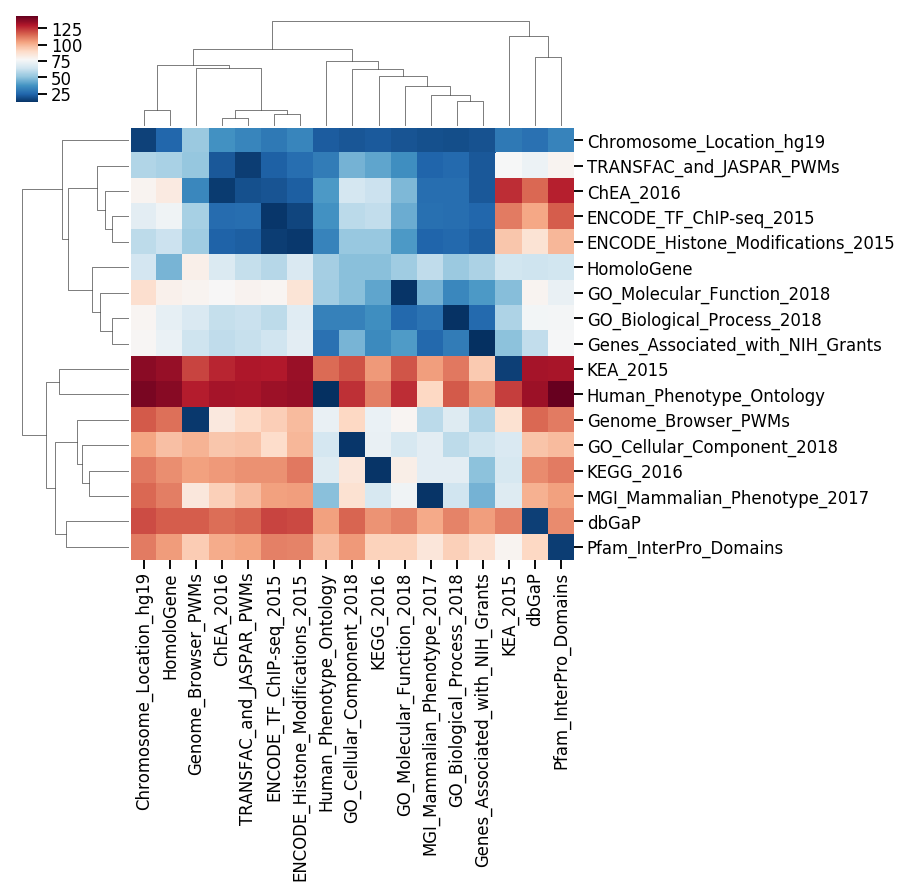

In [18]:
sns.clustermap(np.log2(perplexity_df), cmap='RdBu_r');

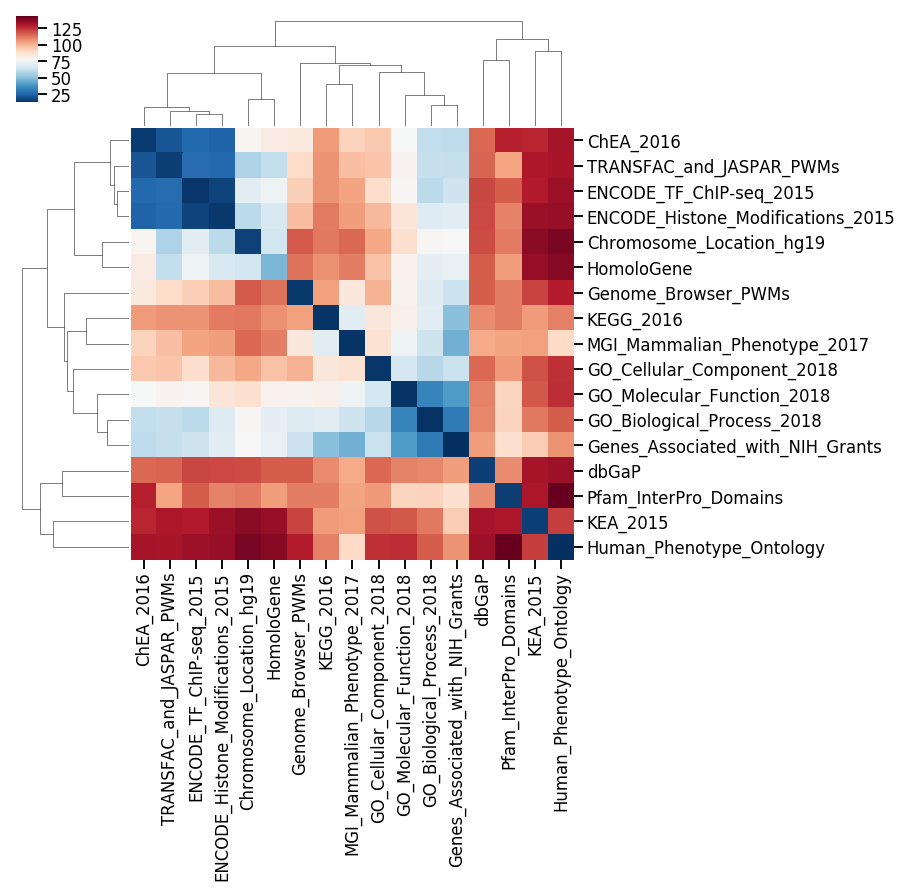

In [19]:
# Force the perplexity_mat to be symetrical
perplexity_mat_sym = perplexity_mat + perplexity_mat.T
sns.clustermap(np.log2(pd.DataFrame(perplexity_mat_sym,
                                   index=lib_names, 
                                    columns=lib_names)), 
               cmap='RdBu_r');

# 2. Use gene function prediction to evaluate the quality of topic models


Steps: 
1. Encode a gene-set library (e.g. KEGG_pathways) as Y (genes by functions)
1. Use Multi-label classification to predict Y: $f(X) = Y$, where X is a genes by topics matrix
1. Examine accuracies from each pathway

In [17]:
# lib used for topic modeling
# libs_x = ['ChEA_2016', 'ENCODE_TF_ChIP-seq_2015']
libs_x = [
    'ChEA_2016', 'ENCODE_TF_ChIP-seq_2015',
    'TRANSFAC_and_JASPAR_PWMs', 'Genome_Browser_PWMs',
    'KEA_2015',
    'GO_Biological_Process_2018', 'GO_Cellular_Component_2018',
    'MGI_Mammalian_Phenotype_2017', 'Human_Phenotype_Ontology',
    'dbGaP', 
    'Genes_Associated_with_NIH_Grants',
    'Chromosome_Location_hg19',
    'Pfam_InterPro_Domains',
    'HomoloGene'    
]
mask_lib_x = np.in1d(terms_df['library'], libs_x)
tf_mat_x = tf_mat[mask_lib_x]
tfidf_mat_x = tfidf_mat[mask_lib_x]
print(tf_mat_x.shape, tfidf_mat_x.shape)

(48969, 32309) (48969, 32309)


In [18]:
lda = decomposition.LatentDirichletAllocation(n_components=n_topics, 
                                              n_jobs=10,
                                              random_state=2018)
lda.fit(tf_mat_x)
print('perplexity (train): %.6f' % lda.perplexity(tf_mat_x))

perplexity (train): 13569.097139


In [19]:
# libs used for evaluation
libs_y = ['KEGG_2016', 
          'GO_Molecular_Function_2018',
          'ENCODE_Histone_Modifications_2015']

for lib in libs_y:
    mask_lib_y = np.in1d(terms_df['library'], [lib])
    tf_mat_y = tf_mat[mask_lib_y]
    print('perplexity (test %s): %.6f' % (lib, lda.perplexity(tf_mat_y)))

perplexity (test KEGG_2016): 2005931592307805077557477376.000000
perplexity (test GO_Molecular_Function_2018): 594958428629824256.000000
perplexity (test ENCODE_Histone_Modifications_2015): 113141.334784


In [20]:
X_topics = lda.components_.T # genes by topics matrix
print(X_topics.shape)

(32309, 100)


In [21]:
import evaluations

In [23]:
knn_scores = evaluations.NN_generalization_accuracy_wrapper(X_topics, libs_y, tf_mat.T, 
                                                terms_df['library'],
                                               dummy=True, 
                                               model_name='baseline')

KEGG_2016 (32309, 293)
GO_Molecular_Function_2018 (32309, 1151)
ENCODE_Histone_Modifications_2015 (32309, 412)


In [24]:
knn_scores_lda = evaluations.NN_generalization_accuracy_wrapper(X_topics, libs_y, tf_mat.T,
                                                                terms_df['library'],
                                               dummy=False, 
                                               model_name='LDA')

KEGG_2016 (32309, 293)
GO_Molecular_Function_2018 (32309, 1151)
ENCODE_Histone_Modifications_2015 (32309, 412)


In [25]:
# Fit an NMF model
nmf = decomposition.NMF(n_components=n_topics, 
                        alpha=.1, 
                        l1_ratio=.5,
                        random_state=2018,)
nmf.fit(tfidf_mat_x)

NMF(alpha=0.1, beta_loss='frobenius', init=None, l1_ratio=0.5, max_iter=200,
  n_components=100, random_state=2018, shuffle=False, solver='cd',
  tol=0.0001, verbose=0)

In [26]:
X_topics_nmf = nmf.components_.T # genes by topics matrix
print(X_topics_nmf.shape)

(32309, 100)


In [27]:
knn_scores_nmf = evaluations.NN_generalization_accuracy_wrapper(X_topics_nmf, libs_y, tf_mat.T, 
                                                                terms_df['library'],
                                               dummy=False, 
                                               model_name='NMF')

KEGG_2016 (32309, 293)
GO_Molecular_Function_2018 (32309, 1151)
ENCODE_Histone_Modifications_2015 (32309, 412)


In [28]:
# Fit an SVD model
svd = decomposition.TruncatedSVD(n_components=n_topics,
                                random_state=2018)
svd.fit(tfidf_mat_x)

TruncatedSVD(algorithm='randomized', n_components=100, n_iter=5,
       random_state=2018, tol=0.0)

In [29]:
X_topics_svd = svd.components_.T # genes by topics matrix
print(X_topics_svd.shape)

(32309, 100)


In [30]:
knn_scores_svd = evaluations.NN_generalization_accuracy_wrapper(X_topics_svd, libs_y, tf_mat.T, 
                                                                terms_df['library'],
                                               dummy=False, 
                                               model_name='SVD')

KEGG_2016 (32309, 293)
GO_Molecular_Function_2018 (32309, 1151)
ENCODE_Histone_Modifications_2015 (32309, 412)


In [ ]:
# Fit NVDM model
model = NVDM(batch_size = 128,
             n_topic=n_topics,
             n_hidden=1000,
             non_linearity='relu',
             learning_rate=5e-4,
             vocab_size=tfidf_mat_x.shape[1])
model.fit(tf_mat_x, n_epochs=10)


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
| Epoch train: 1 | updating decoder 0 | Corpus ppx: 27959.73570 | KLD: 0.22454


In [23]:
model.save('../data/models/NVDM-10epochs-on-14-GMTs')

'../data/models/NVDM-10epochs-on-14-GMTs/model.ckpt'

In [24]:
import scipy.sparse as sp

In [25]:
X_topics_nvdm_10 = model.transform(sp.eye(tf_mat_x.shape[1]))
X_topics_nvdm_10.shape

(32309, 100)

In [36]:
knn_scores_nvdm_10 = evaluations.NN_generalization_accuracy_wrapper(X_topics_nvdm_10, libs_y, tf_mat.T, 
                                                                terms_df['library'],
                                               dummy=False, 
                                               model_name='NVDM-10')

KEGG_2016 (32309, 293)
GO_Molecular_Function_2018 (32309, 1151)
ENCODE_Histone_Modifications_2015 (32309, 412)


In [26]:
# Continue training NVDM
model.fit(tf_mat_x, n_epochs=10)

| Epoch train: 1 | updating decoder 0 | Corpus ppx: 8123.70585 | KLD: 24.966
| Epoch train: 1 | updating decoder 1 | Corpus ppx: 6101.57743 | KLD: 24.966
| Epoch train: 1 | updating decoder 2 | Corpus ppx: 6080.18948 | KLD: 24.966
| Epoch train: 1 | updating decoder 3 | Corpus ppx: 6408.12600 | KLD: 24.966
| Epoch train: 1 | updating decoder 4 | Corpus ppx: 6166.91020 | KLD: 24.966
| Epoch train: 1 | updating decoder 5 | Corpus ppx: 7135.22146 | KLD: 24.966
| Epoch train: 1 | updating decoder 6 | Corpus ppx: 6654.12988 | KLD: 24.966
| Epoch train: 1 | updating decoder 7 | Corpus ppx: 8300.35404 | KLD: 24.966
| Epoch train: 1 | updating decoder 8 | Corpus ppx: 7003.10069 | KLD: 24.966
| Epoch train: 1 | updating decoder 9 | Corpus ppx: 6003.59628 | KLD: 24.966
| Epoch train: 1 | updating encoder 0 | Corpus ppx: 5822.61946 | KLD: 24.72
| Epoch train: 1 | updating encoder 1 | Corpus ppx: 5884.51222 | KLD: 24.896
| Epoch train: 1 | updating encoder 2 | Corpus ppx: 6003.69980 | KLD: 24.978


/Users/maayanlab/Documents/GitHub/tensorflow-playground/nvdm.py:204: RuntimeWarning: overflow encountered in exp
  ppx = np.exp(loss_sum / word_count)


| Epoch train: 3 | updating encoder 1 | Corpus ppx: inf | KLD: 6.0473e+07
| Epoch train: 3 | updating encoder 2 | Corpus ppx: 75434216809875.45312 | KLD: 927.47
| Epoch train: 3 | updating encoder 3 | Corpus ppx: inf | KLD: 3.5993e+07
| Epoch train: 3 | updating encoder 4 | Corpus ppx: 1072002049381665774615806708897267824928489412798743557114765955133652196218140666934555673744113664.00000 | KLD: 1.5068e+04
| Epoch train: 3 | updating encoder 5 | Corpus ppx: 49208214526451145735039183667331072.00000 | KLD: 2421.1
| Epoch train: 3 | updating encoder 6 | Corpus ppx: 100455.51099 | KLD: 127.75
| Epoch train: 3 | updating encoder 7 | Corpus ppx: 24003.71319 | KLD: 38.185
| Epoch train: 3 | updating encoder 8 | Corpus ppx: 10077.18064 | KLD: 29.532
| Epoch train: 3 | updating encoder 9 | Corpus ppx: 377897.36074 | KLD: 170.29
| Epoch train: 4 | updating decoder 0 | Corpus ppx: 706665350169467546509352865068736915629279009974896862588034014777673859569979647590400.00000 | KLD: 9792.6
| Epoc

| Epoch train: 8 | updating decoder 3 | Corpus ppx: 9033.34001 | KLD: 29.015
| Epoch train: 8 | updating decoder 4 | Corpus ppx: 6831.50754 | KLD: 29.015
| Epoch train: 8 | updating decoder 5 | Corpus ppx: 9713.59069 | KLD: 29.015
| Epoch train: 8 | updating decoder 6 | Corpus ppx: 8888.77168 | KLD: 29.015
| Epoch train: 8 | updating decoder 7 | Corpus ppx: 8312.55044 | KLD: 29.015
| Epoch train: 8 | updating decoder 8 | Corpus ppx: 6552.96863 | KLD: 29.015
| Epoch train: 8 | updating decoder 9 | Corpus ppx: 6450.57592 | KLD: 29.015
| Epoch train: 8 | updating encoder 0 | Corpus ppx: 6885.32725 | KLD: 28.513
| Epoch train: 8 | updating encoder 1 | Corpus ppx: inf | KLD: 4.7199e+06
| Epoch train: 8 | updating encoder 2 | Corpus ppx: 6947.32943 | KLD: 28.415
| Epoch train: 8 | updating encoder 3 | Corpus ppx: 657627.26966 | KLD: 69.523
| Epoch train: 8 | updating encoder 4 | Corpus ppx: 18475605744.67412 | KLD: 734.12
| Epoch train: 8 | updating encoder 5 | Corpus ppx: inf | KLD: 7.2388e

NVDM(batch_size=128, learning_rate=0.0005, n_hidden=1000, n_sample=1,
   n_topic=100, non_linearity='tanh', vocab_size=32309)

In [27]:
model.save('../data/models/NVDM-20epochs-on-14-GMTs')

'../data/models/NVDM-20epochs-on-14-GMTs/model.ckpt'

In [40]:
X_topics_nvdm_20 = model.transform(sp.eye(tf_mat_x.shape[1]))
X_topics_nvdm_20.shape

(32309, 100)

In [41]:
knn_scores_nvdm_20 = evaluations.NN_generalization_accuracy_wrapper(X_topics_nvdm_20, libs_y, tf_mat.T, 
                                                                terms_df['library'],
                                               dummy=False, 
                                               model_name='NVDM-20')

KEGG_2016 (32309, 293)
GO_Molecular_Function_2018 (32309, 1151)
ENCODE_Histone_Modifications_2015 (32309, 412)


In [42]:
knn_scores_all = pd.concat([knn_scores, knn_scores_lda, knn_scores_nmf, knn_scores_svd,
                            knn_scores_nvdm_10,
                            knn_scores_nvdm_20,
                           ])
knn_scores_all.shape

(90, 3)

/Users/maayanlab/Documents/Zichen_Projects/venv3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


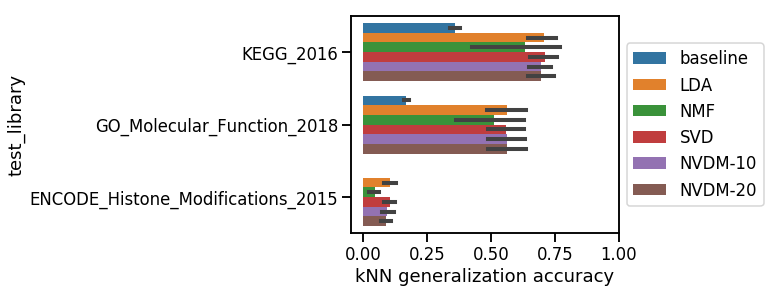

In [43]:
ax = sns.barplot(y='test_library', x='accuracy', data=knn_scores_all, hue='model')
# ax = sns.swarmplot(y='test_library', x='accuracy', data=knn_scores_all, hue='model')
ax.set_xlabel('kNN generalization accuracy')
ax.set_xlim([-0.05, 1]);
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5));

In [36]:
from joblib import load, dump

In [37]:
len(libs_x)

14

In [38]:
dump(lda, '../data/models/LDA-on-14-GMTs.joblib')
dump(nmf, '../data/models/NMF-on-14-GMTs.joblib')
dump(svd, '../data/models/SVD-on-14-GMTs.joblib')

['../data/models/SVD-on-14-GMTs.joblib']

# 3. Evaluate by reconstruction error for the test set (excluding LDA)

In [39]:
reconstruction_errors_df = {}
for lib in libs_y:
    mask_lib_y = np.in1d(terms_df['library'], [lib])
    Y = tfidf_mat[mask_lib_y].toarray() # genes by functions binary matrix
    
    Y_recon_nmf = nmf.inverse_transform(nmf.transform(Y))
    mse_nmf = metrics.mean_absolute_error(Y, Y_recon_nmf)
    
    Y_recon_svd = svd.inverse_transform(svd.transform(Y))
    mse_svd = metrics.mean_absolute_error(Y, Y_recon_svd)
    
    print(lib, Y.shape)
    
    reconstruction_errors_df[lib] = [mse_nmf, mse_svd]

KEGG_2016 (293, 32309)
GO_Molecular_Function_2018 (1151, 32309)
ENCODE_Histone_Modifications_2015 (412, 32309)


In [40]:
reconstruction_errors_df = pd.DataFrame(reconstruction_errors_df, index=['NMF', 'SVD'])
reconstruction_errors_df

KEGG_2016  GO_Molecular_Function_2018  ENCODE_Histone_Modifications_2015
NMF   0.000336                    0.000196                           0.002040
SVD   0.000561                    0.000354                           0.002258

# 4. Examine top words from each learned topics

In [41]:
for i in range(lda.components_.shape[0]):
    top_word_idx = lda.components_[i].argsort()[::-1][:10]
    top_words = genes[top_word_idx]
    top_weights = lda.components_[i][top_word_idx]
    print('Topic-%d: %s' % (i, ', '.join(top_words)))

Topic-0: ITGA2B, ITGB3, ANGPT2, KMT2A, CEBPA, P2RY12, FLT3, FIGF, NPM1, CXCL12
Topic-1: CXCR4, CD4, CCR5, CXCL12, GRB2, SRC, FYN, ABL1, TSG101, CRK
Topic-2: TNF, IL6, TLR4, IL1B, IL10, IFNG, TLR2, CXCL8, IL4, ICAM1
Topic-3: TP53, MDM2, CDKN2A, CDKN1A, HIF1A, RB1, MYC, CTNNB1, SUMO1, TP73
Topic-4: IKBKB, CHUK, MAPK8, TRAF6, IKBKG, RIPK1, MAP3K7, TRAF2, NFKB1, FADD
Topic-5: ESR1, LEP, PPARG, ESR2, ADIPOQ, LEPR, INS, PGR, IGF1, PPARGC1A
Topic-6: DDX5, RNPS1, TRAP1, COPS8, PPP2R4, MRPL12, NFX1, NUP155, MRPL1, DCP1A
Topic-7: HDAC1, AR, EP300, CREBBP, HDAC2, CREB1, HDAC3, RXRA, SP1, SMARCA4
Topic-8: AKT1, CDK1, CDK2, PTEN, PRKCD, CSNK2A1, PIK3CA, PIK3CG, PPP2CA, PIK3R1
Topic-9: COL2A1, COL1A1, COL1A2, FBN1, COL11A1, GNPTAB, FLNA, COL11A2, FLNB, IDUA
Topic-10: MAP1LC3B, ABCB8, PARP9, UGT1A3, ECE2, MATR3, ZCCHC14, PKM2, HNRPUL1, ALG3
Topic-11: GSTM1, GSTT1, GSTP1, CCR2, CYP1A1, CYP2E1, TNF, NAT2, FLOT1, BRD2
Topic-12: CCL3, CCL4, CCL5, CCL11, CCL7, CCL26, CCL18, CCL8, CCL2, CCL23
Topic-13: TRI

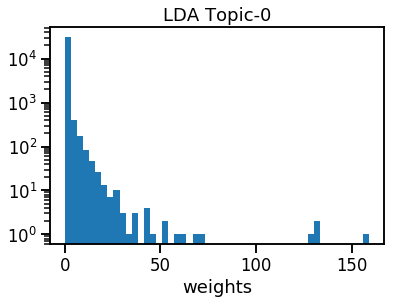

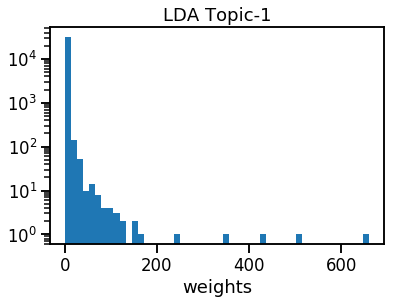

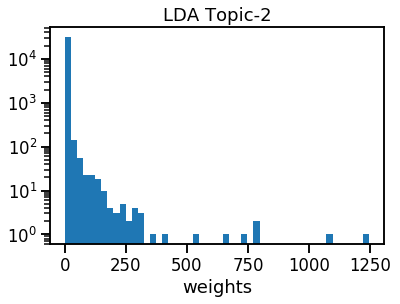

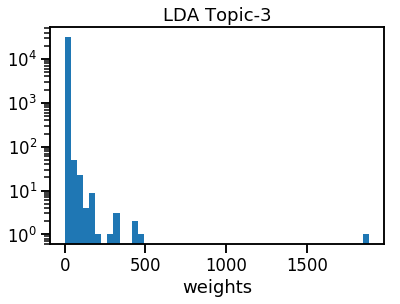

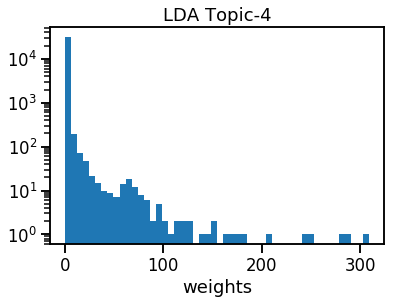

In [52]:
# Are the genes in each topics sparse?
for i in range(5):
    plt.hist(lda.components_[i], bins=50, log=True);
    plt.xlabel('weights')
    plt.title('LDA Topic-%d'%i)
    plt.show()

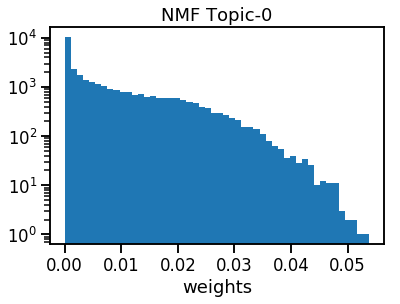

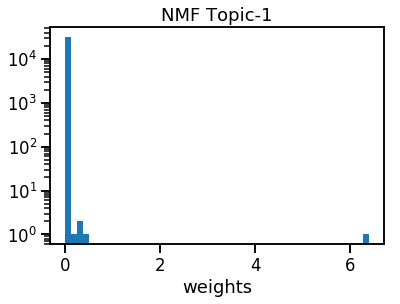

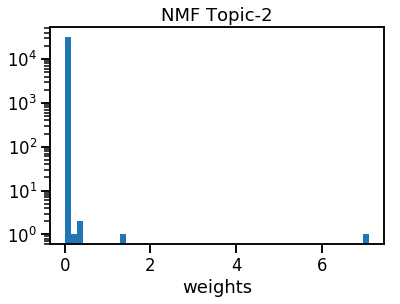

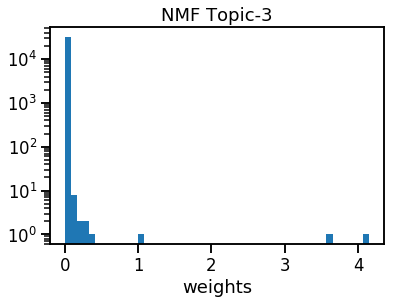

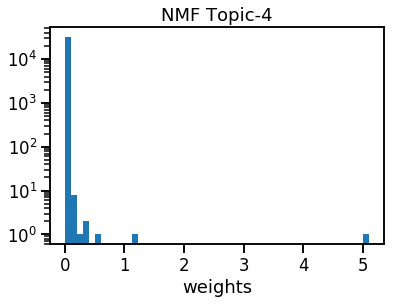

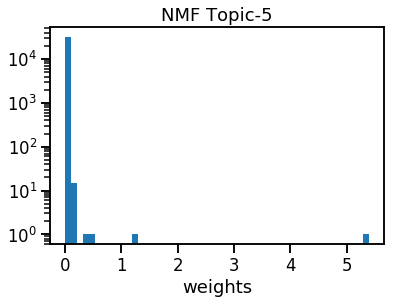

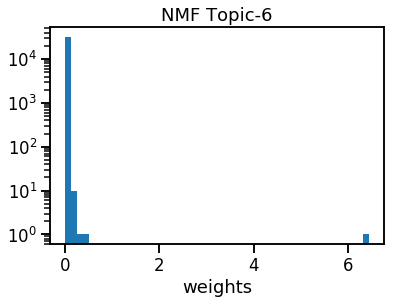

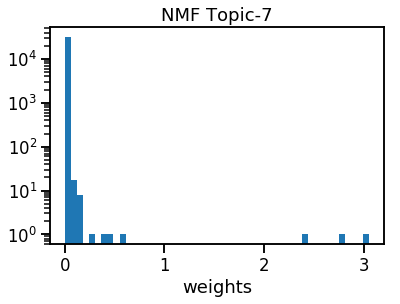

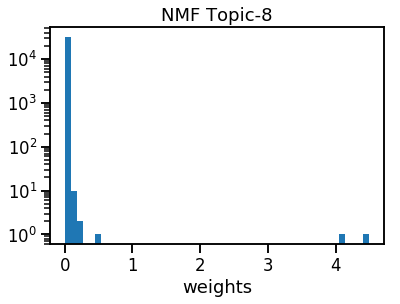

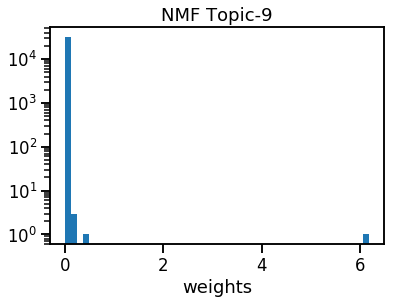

In [54]:
for i in range(10):
    plt.hist(nmf.components_[i], bins=50, log=True);
    plt.xlabel('weights')
    plt.title('NMF Topic-%d'%i)
    plt.show()

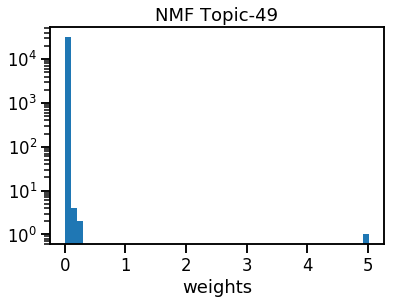

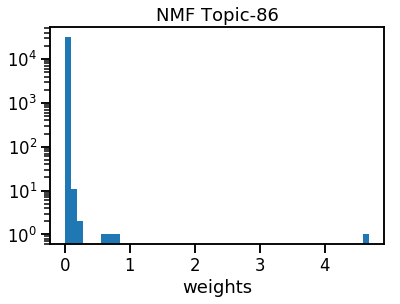

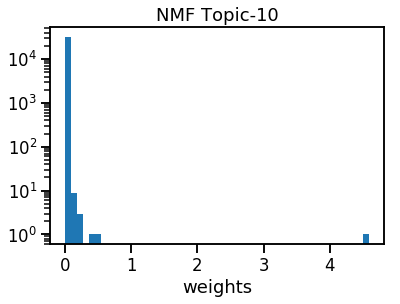

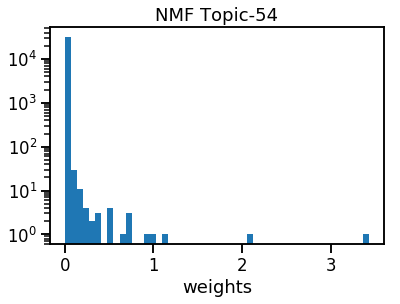

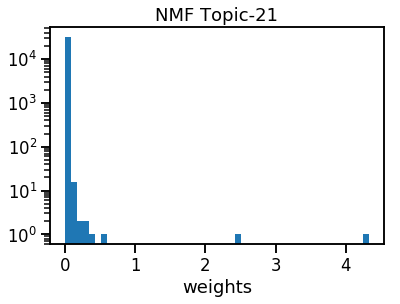

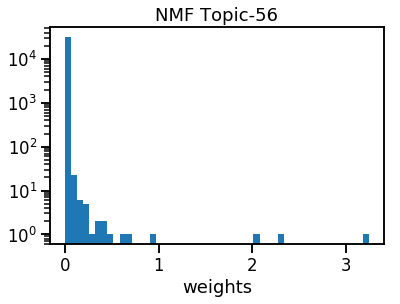

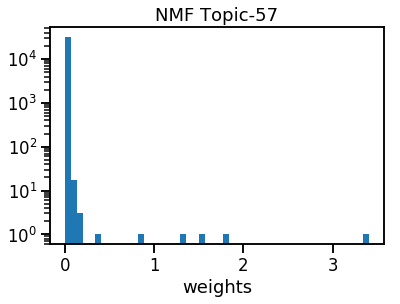

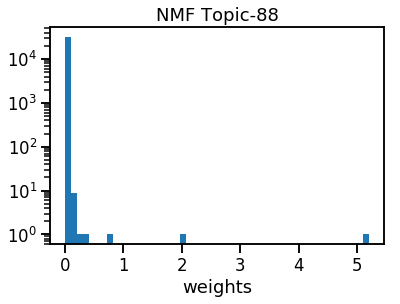

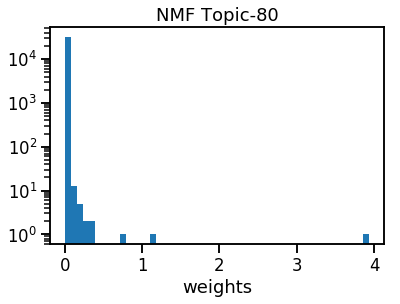

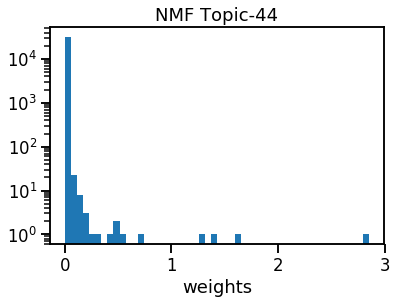

In [60]:
for i in np.random.choice(n_topics, 10):
    plt.hist(nmf.components_[i], bins=50, log=True);
    plt.xlabel('weights')
    plt.title('NMF Topic-%d'%i)
    plt.show()

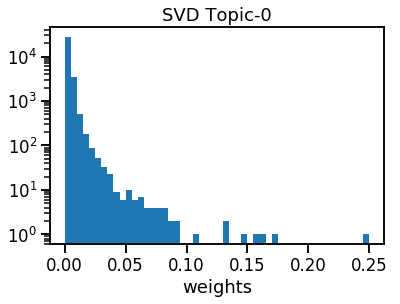

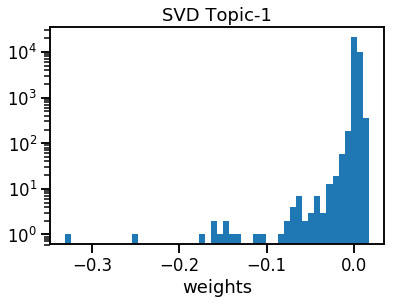

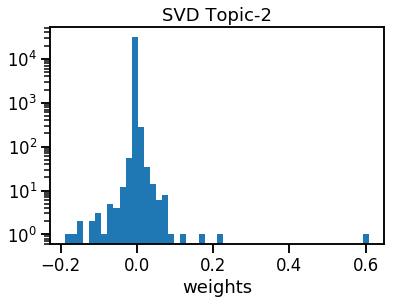

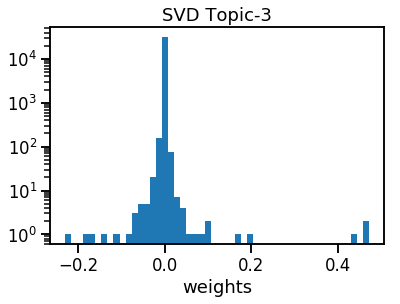

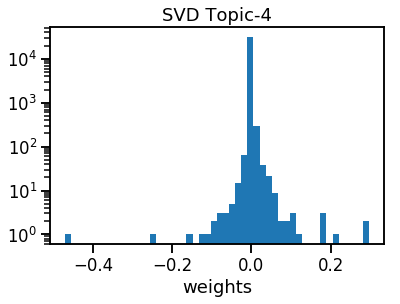

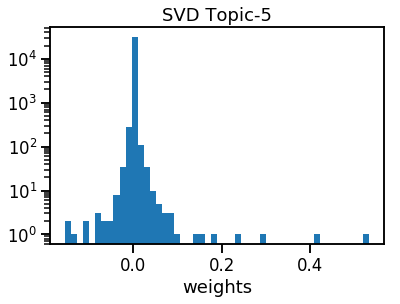

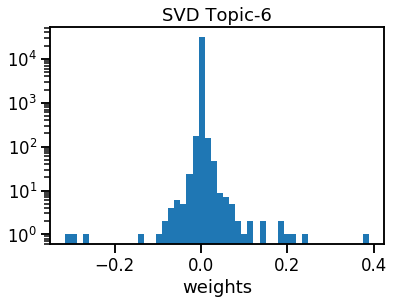

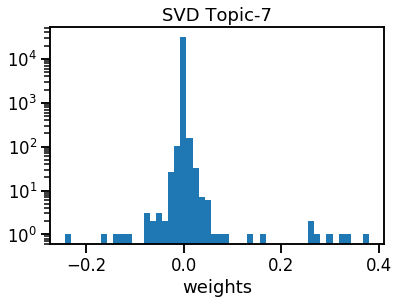

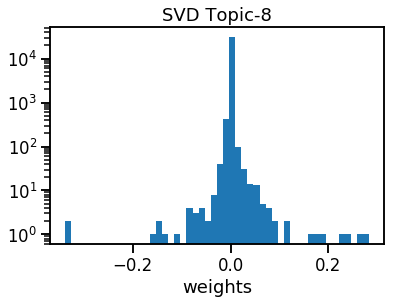

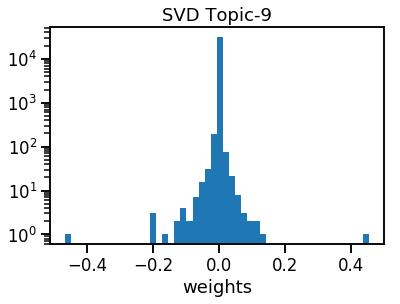

In [55]:
for i in range(10):
    plt.hist(svd.components_[i], bins=50, log=True);
    plt.xlabel('weights')
    plt.title('SVD Topic-%d'%i)
    plt.show()

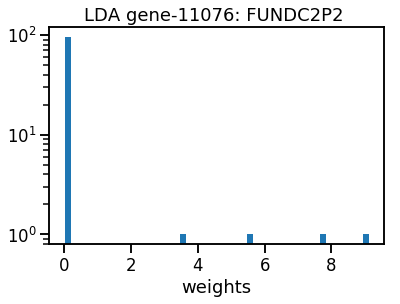

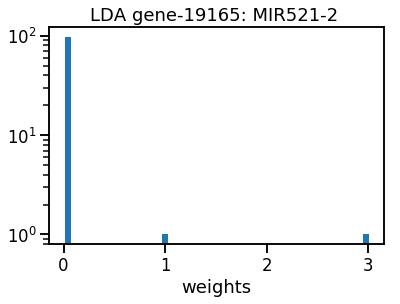

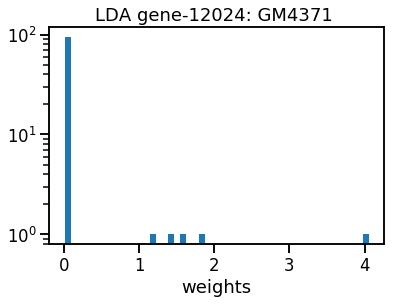

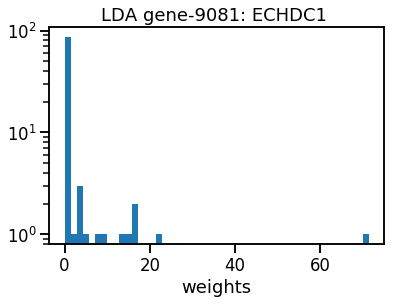

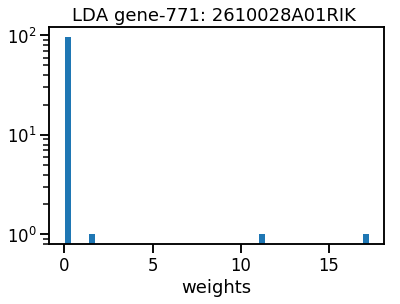

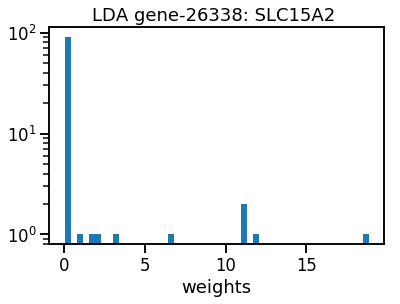

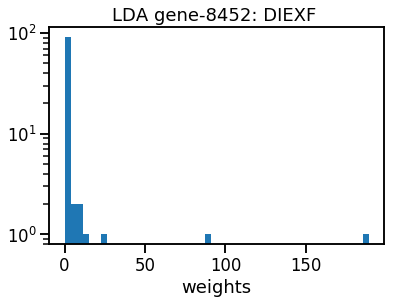

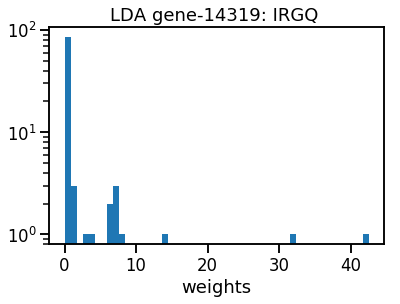

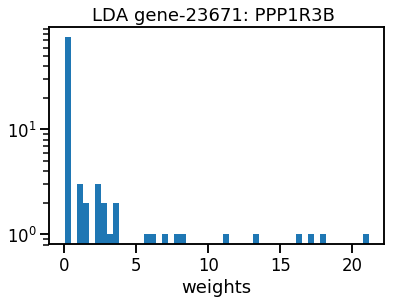

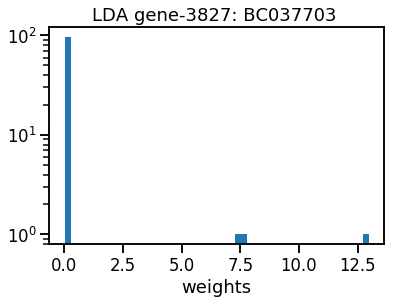

In [57]:
# Can genes be assigned multiple topics?
for j in np.random.choice(len(genes), 10):
    plt.hist(lda.components_[:, j], bins=50, log=True);
    plt.xlabel('weights')
    plt.title('LDA gene-%d: %s '% (j, genes[j]))
    plt.show()

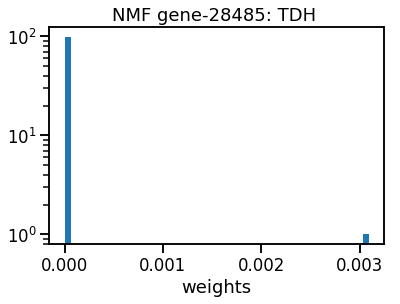

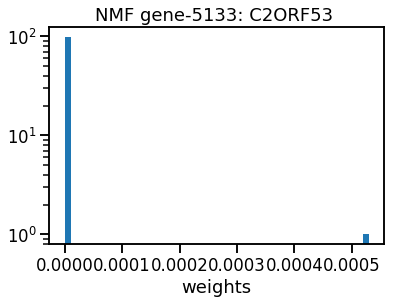

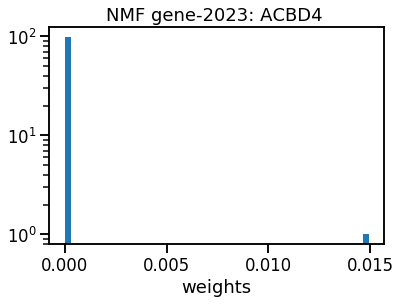

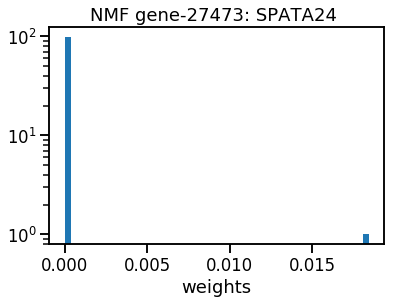

/Users/maayanlab/Documents/Zichen_Projects/venv3/lib/python3.6/site-packages/matplotlib/axes/_base.py:3471: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=100.0, top=100.0
  'bottom=%s, top=%s') % (bottom, top))


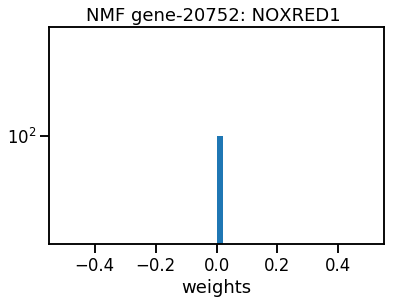

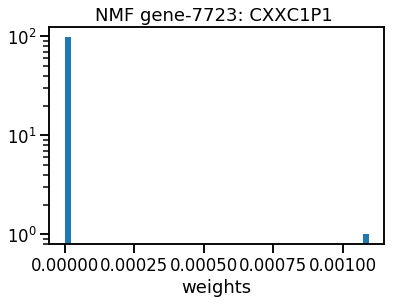

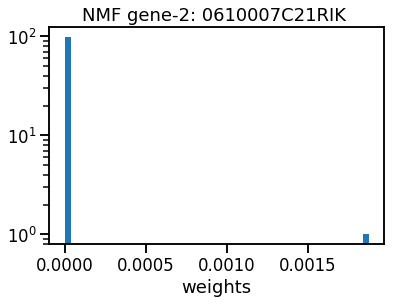

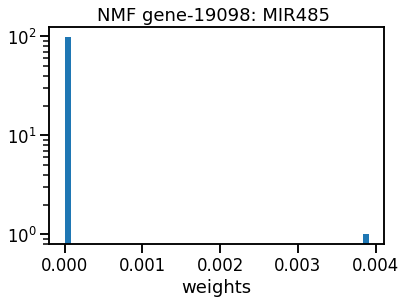

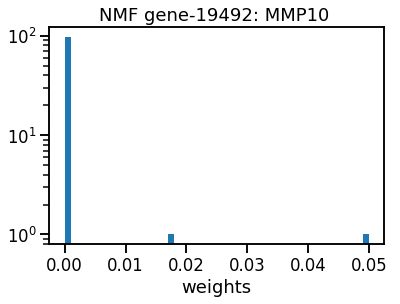

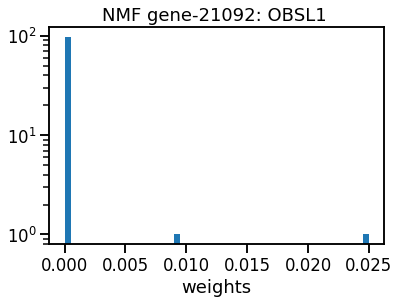

In [61]:
# Can genes be assigned multiple topics?
for j in np.random.choice(len(genes), 10):
    plt.hist(nmf.components_[:, j], bins=50, log=True);
    plt.xlabel('weights')
    plt.title('NMF gene-%d: %s '% (j, genes[j]))
    plt.show()

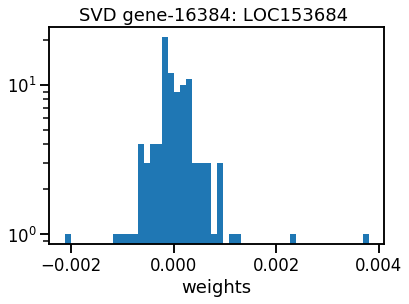

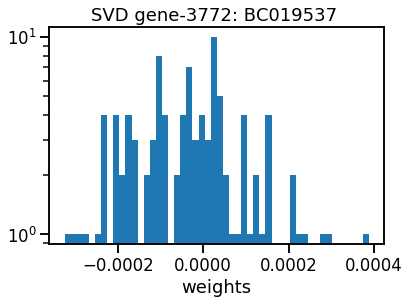

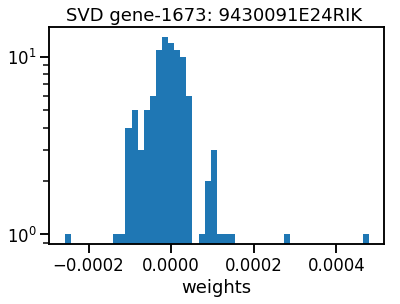

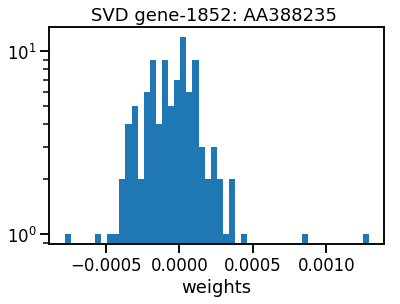

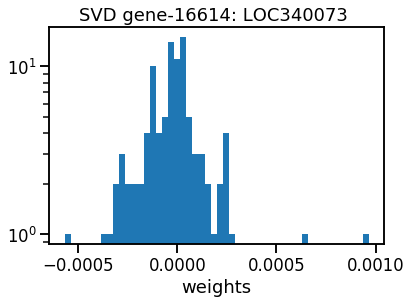

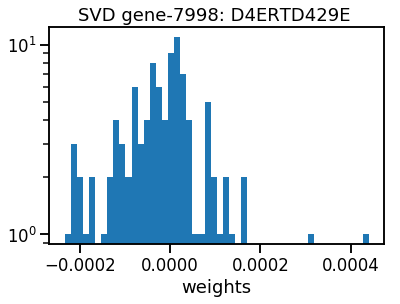

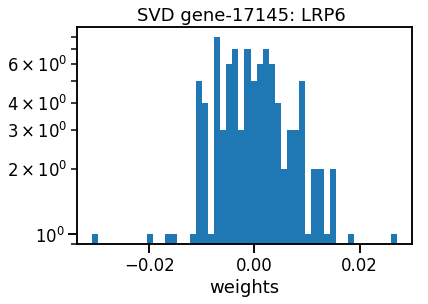

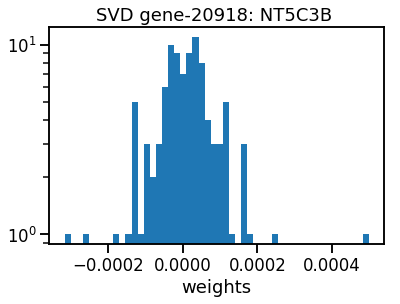

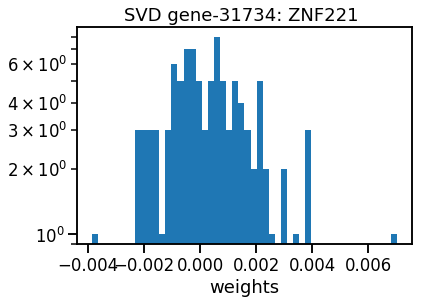

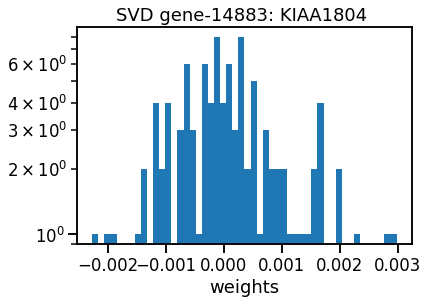

In [62]:
# Can genes be assigned multiple topics?
for j in np.random.choice(len(genes), 10):
    plt.hist(svd.components_[:, j], bins=50, log=True);
    plt.xlabel('weights')
    plt.title('SVD gene-%d: %s '% (j, genes[j]))
    plt.show()

In [63]:
lda.components_.shape

(100, 32309)

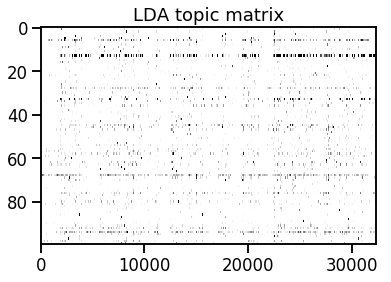

In [94]:
plt.imshow(lda.components_, aspect='auto', cmap='binary',
          vmin=0, vmax=50);
plt.title('LDA topic matrix');

In [95]:
lda.components_.min(), lda.components_.max()

(0.01, 1886.2477760311933)

In [96]:
nmf.components_.min(), nmf.components_.max()

(0.0, 7.101103135561953)

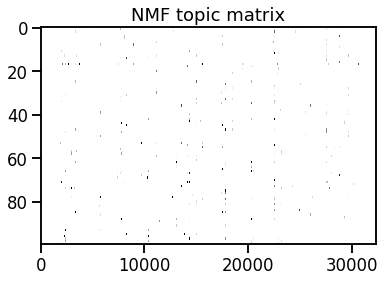

In [97]:
plt.imshow(nmf.components_, aspect='auto', cmap='binary',
          vmin=0, vmax=.1);
plt.title('NMF topic matrix');

In [98]:
svd.components_.min(), svd.components_.max()

(-0.4714223898840381, 0.62691875171101)

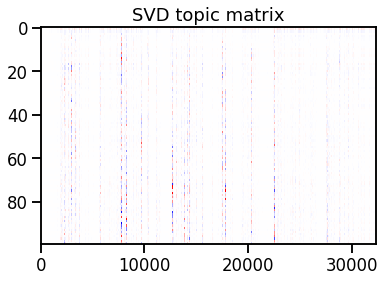

In [99]:
plt.imshow(svd.components_, aspect='auto', cmap='bwr',
          vmin=-.1, vmax=.1);
plt.title('SVD topic matrix');

In [44]:
X_topics_nvdm_20.shape

(32309, 100)

In [45]:
X_topics_nvdm_20.min(), X_topics_nvdm_20.max()

(-2.5425463, 2.059555)

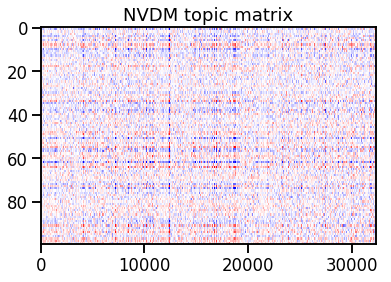

In [47]:
plt.imshow(X_topics_nvdm_20.T, aspect='auto', cmap='bwr',
          vmin=-1, vmax=1);
plt.title('NVDM topic matrix');

In [42]:
topic_df = pd.DataFrame(lda.components_.T, 
                        index=genes, 
                        columns=['Topic-%d' % i for i in range(n_topics)])
topic_df.shape

(32309, 100)

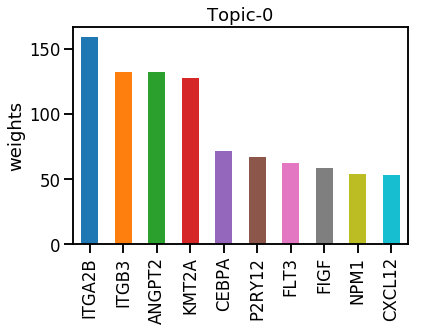

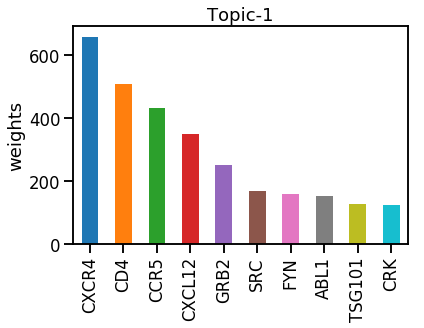

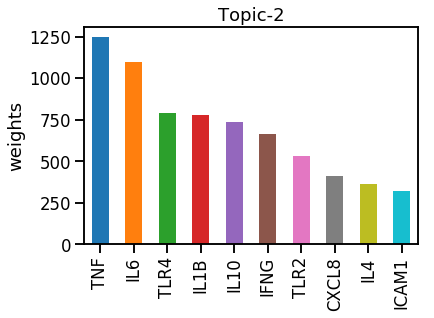

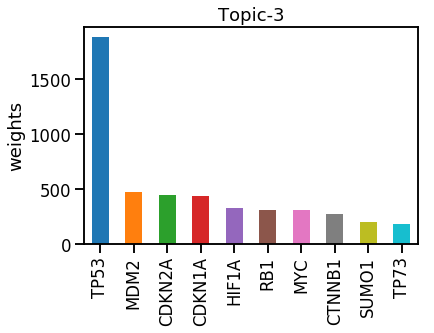

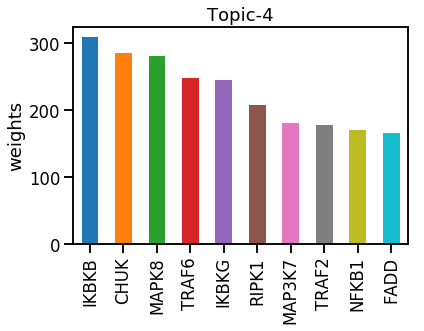

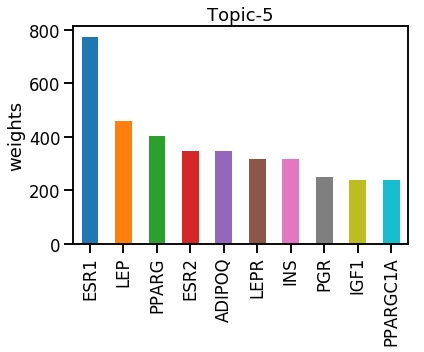

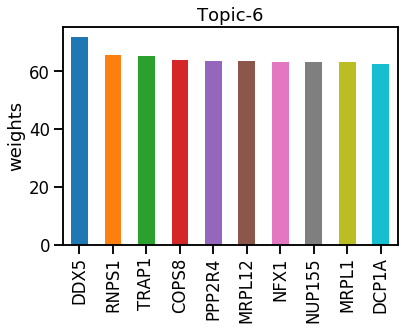

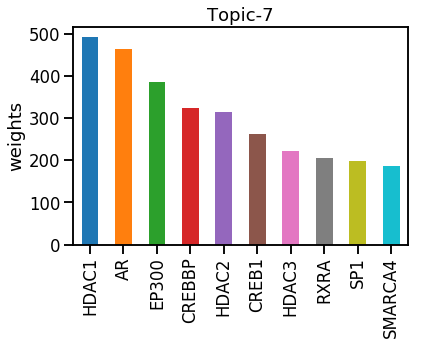

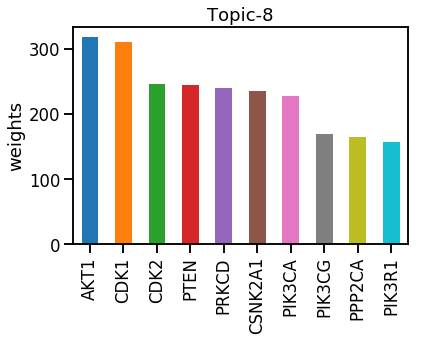

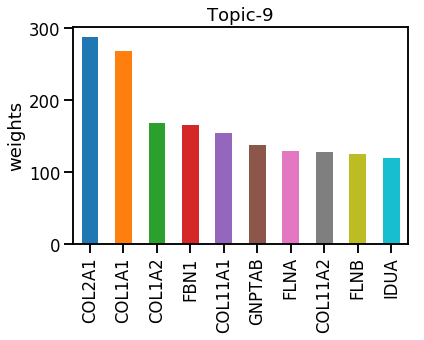

In [43]:
for col in topic_df.columns[:10]:
    ax = topic_df[col].sort_values(ascending=False).head(10).plot(kind='bar')
    ax.set_ylabel('weights')
    ax.set_title(col)
    plt.show()

# 4. gene2vec

In [44]:
def find_most_similar_genes(gene_of_interest, models, model_names):
    for model, model_name in zip(models, model_names):
        gene2vec_mat = model.components_.T

        # find the index of the gene
        idx = np.where(genes == gene_of_interest)[0][0]
        # compute the pdist of this gene with all genes
        cosine_dists = metrics.pairwise_distances(X=gene2vec_mat, 
                                                  Y=gene2vec_mat[idx].reshape(1, -1),
                                                 metric='cosine')

        cosine_dists = cosine_dists.flatten()
        # sort the pdists
        top_genes = genes[cosine_dists.argsort()][:10]
        top_dists = cosine_dists[cosine_dists.argsort()][:10]

        fig, ax = plt.subplots()
        ax.barh(np.arange(10), top_dists, 
                tick_label=top_genes);
        ax.set_xlabel('Cosine distance with %s' % gene_of_interest);
        ax.set_title('gene2vec (%s)' % model_name);

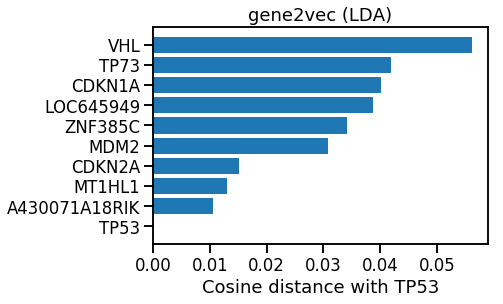

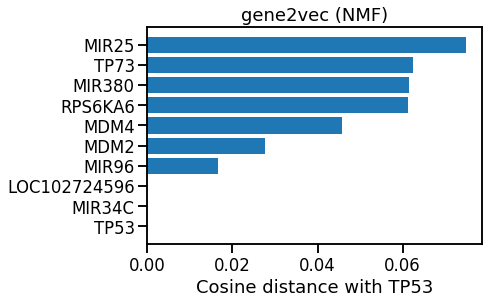

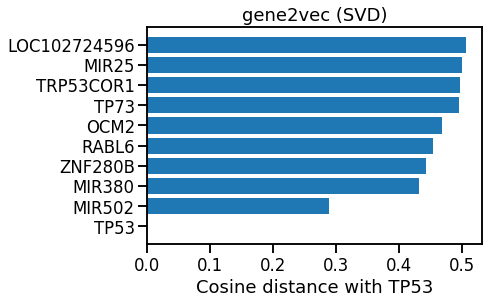

In [45]:
# Find the most similar genes with a gene in the vector space
find_most_similar_genes('TP53', [lda, nmf, svd], ['LDA', 'NMF', 'SVD'])

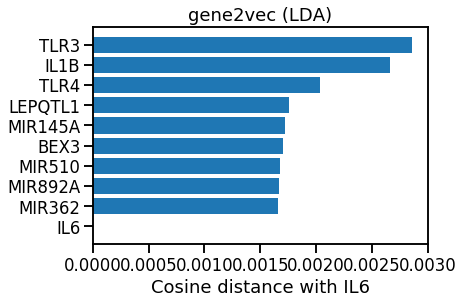

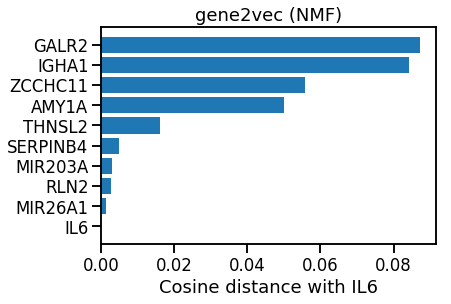

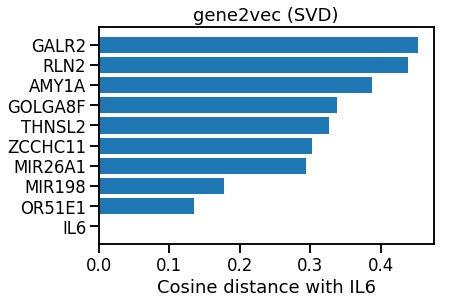

In [46]:
find_most_similar_genes('IL6', [lda, nmf, svd], ['LDA', 'NMF', 'SVD'])

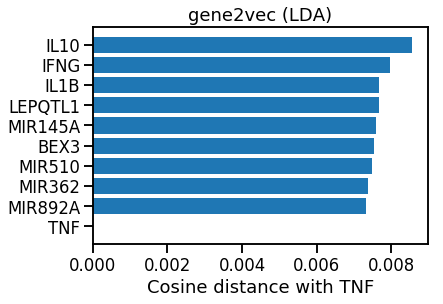

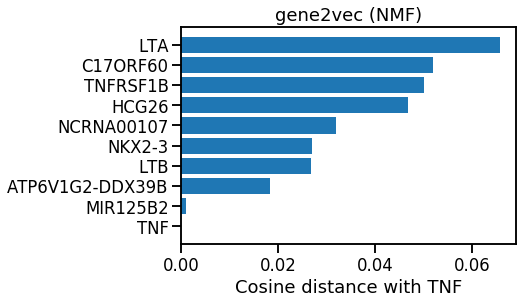

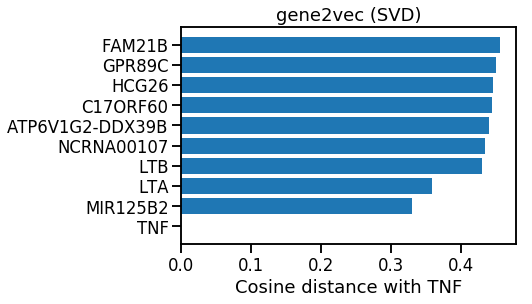

In [47]:
find_most_similar_genes('TNF', [lda, nmf, svd], ['LDA', 'NMF', 'SVD'])

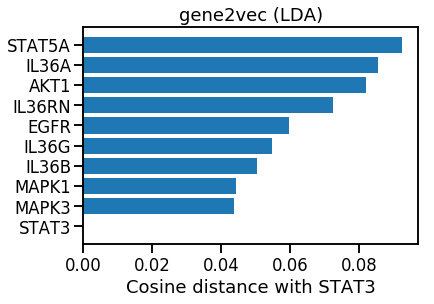

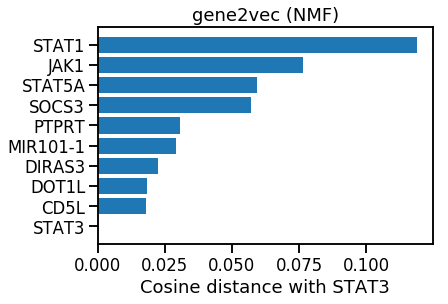

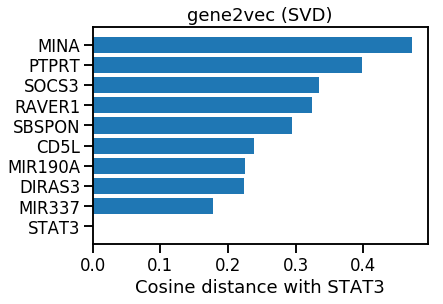

In [48]:
find_most_similar_genes('STAT3', [lda, nmf, svd], ['LDA', 'NMF', 'SVD'])